In [1]:
import csv
import itertools
import time
import timeit

import numpy as np

from skimage.filters import threshold_mean
from skimage.morphology import skeletonize
from skimage import graph as skgraph

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

from utils.plotting import *
from utils.process import *

# Intro

## Read in MNIST data

In [2]:
mnist_filename = '../data/mnist/mnist_test.csv'
mnist_images_raw, mnist_labels = read_in_mnist(mnist_filename)


In [3]:
print(len(mnist_images_raw))
print(len(mnist_labels))


10000
10000


## A full processing pipeline

### Test the full processing pipeline's runtime

`timeit.default_timer()` measurements can be affected by other programs running on the same machine, so the best thing to do when accurate timing is necessary is to repeat the timing a few times and use the best time. The `-r` option is good for this; the default of 5 repetitions is probably enough in most cases. You can use `time.process_time()` to measure CPU time.

But we can only use `-r` for repetitions from the command line.

In [4]:
start = timeit.default_timer()
#start = time.process_time()

result_dict_list = [TGGLinesPlus(img) for img in mnist_images_raw]

stop = timeit.default_timer()
#stop = time.process_time()

print(f"Time to run: {(stop - start):.5f}s")  


Time to run: 38.26927s


#### Timing
So the entire MNIST dataset takes about `~37-38s` to run.

In [5]:
# pick a random image and plot the skeleton graph's paths
# good example to work with: number 8 at index 3406
# idx = np.random.randint(0, len(result_dict_list))
idx = 3406
label = mnist_labels[idx]
result_dict = result_dict_list[idx]


In [6]:
# list(result_dict.keys())


In [7]:
skeleton = result_dict["skeleton"]
graph = result_dict["skeleton_graph"]
coordinates = result_dict["skeleton_coordinates"]
node_types = result_dict["node_types"]
search_by_node = result_dict["search_by_node"]

junction_locations = result_dict["junction_locations"]
junction_subgraph = result_dict["junction_subgraph"]
cliques = result_dict["cliques"]
unique_cliques = result_dict["cliques_unique"]
primary_junctions = result_dict["junctions_primary"]


### This is how each plotting method should be called.

In [8]:
# plot_networkx_graph(skeleton, graph, coordinates)


In [9]:
# the before and after graphs are only different if connectivity=1
# display_updated_graphs(result_dict)


In [10]:
# plot_junctions(result_dict, label, idx)


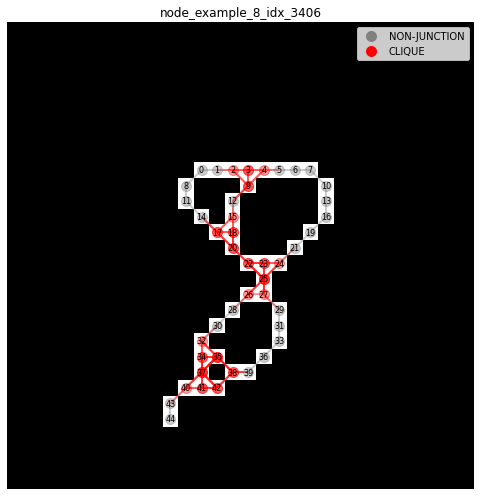

In [11]:
plot_cliques(result_dict, label, idx)


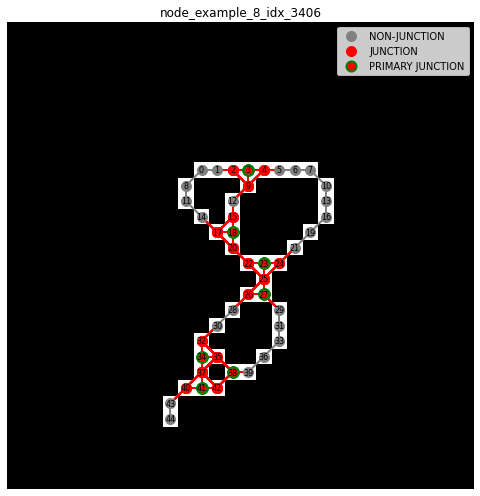

In [12]:
plot_primary_junctions(result_dict, label, idx)


## Path segmentation

In [13]:
path_seg_graph = result_dict["skeleton_graph_path_seg"]
removed_edges = result_dict["removed_edges"]
end_nodes = result_dict["nodes_terminal"]
path_seg_endpoints = result_dict["endpoints_path_seg"]


In [14]:
# make sure that we successfully subtracted the right number of edges
num_edges = len(graph.edges()) - len(path_seg_graph.edges()) 
assert(num_edges == len(removed_edges))


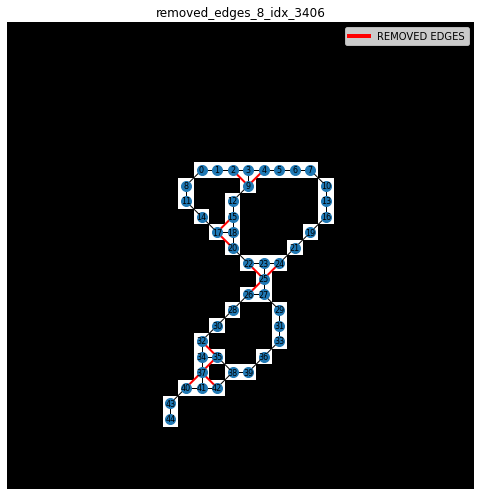

In [15]:
plot_removed_edges(result_dict, label, idx)

### Walking from terminals-junctions and junctions-junctions

As a reminder, here is how we currently define different junction types: <br>
**J**: *junction node*, `degree >= 3` <br>
**T**: *turning node*, `degree = 2` <br>
**E**: *end node*, `degree = 1` <br>
**I**: *isolated node*, `degree = 0` <br>

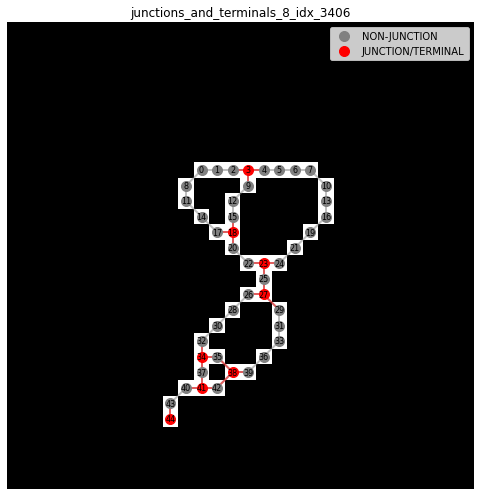

In [16]:
plot_junctions_and_terminals(result_dict, label, idx)

In [17]:
# initial_paths_list: a nested list of lists of paths between a start and end node
initial_paths_list = get_initial_paths(path_seg_graph, path_seg_endpoints)
initial_paths_list


[[3, 2, 1, 0, 8, 11, 14, 17, 18],
 [3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23, 22, 20, 18],
 [3, 9, 12, 15, 18],
 [18, 15, 12, 9, 3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23],
 [18, 17, 14, 11, 8, 0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23],
 [18, 20, 22, 23],
 [23, 25, 27],
 [27, 26, 28, 30, 32, 34],
 [27, 29, 31, 33, 36, 39, 38, 35, 34],
 [27, 29, 31, 33, 36, 39, 38, 42, 41, 37, 34],
 [34, 32, 30, 28, 26, 27, 29, 31, 33, 36, 39, 38],
 [34, 35, 38],
 [34, 37, 41, 42, 38],
 [38, 35, 34, 37, 41],
 [38, 39, 36, 33, 31, 29, 27, 26, 28, 30, 32, 34, 37, 41],
 [38, 42, 41],
 [41, 40, 43, 44]]

In [18]:
# shorten paths, remove duplicate lists
short_paths_list = sorted(list(set([tuple(shorten_path(path, path_seg_endpoints)) for path in initial_paths_list])))

# convert each path back to list type from type tuple
short_paths_list = [list(path) for path in short_paths_list]
short_paths_list


[[3, 2, 1, 0, 8, 11, 14, 17, 18],
 [3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23],
 [3, 9, 12, 15, 18],
 [18, 15, 12, 9, 3],
 [18, 17, 14, 11, 8, 0, 1, 2, 3],
 [18, 20, 22, 23],
 [23, 25, 27],
 [27, 26, 28, 30, 32, 34],
 [27, 29, 31, 33, 36, 39, 38],
 [34, 32, 30, 28, 26, 27],
 [34, 35, 38],
 [34, 37, 41],
 [38, 35, 34],
 [38, 39, 36, 33, 31, 29, 27],
 [38, 42, 41],
 [41, 40, 43, 44]]

So we can see that path `[3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23, 22, 20, 18]` became `[3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23]` because `23` is a primary junction node. 

Now, we want to find paths that are reverses of each other. This prevents the problem of "backtracking" paths that we have already covered.

In [19]:
final_paths_list = find_reversed_list(short_paths_list)
final_paths_list


[[3, 2, 1, 0, 8, 11, 14, 17, 18],
 [3, 4, 5, 6, 7, 10, 13, 16, 19, 21, 24, 23],
 [3, 9, 12, 15, 18],
 [18, 20, 22, 23],
 [23, 25, 27],
 [27, 26, 28, 30, 32, 34],
 [27, 29, 31, 33, 36, 39, 38],
 [34, 35, 38],
 [34, 37, 41],
 [38, 42, 41],
 [41, 40, 43, 44]]

The following paths were removed:
- `[18, 17, 14, 11, 8, 0, 1, 2, 3]` since `[3, 2, 1, 0, 8, 11, 14, 17, 18]` exists
- `[18, 15, 12, 9, 3]` since `[3, 9, 12, 15, 18]` exists
- `[34, 32, 30, 28, 26, 27]` since `[27, 26, 28, 30, 32, 34]` exists

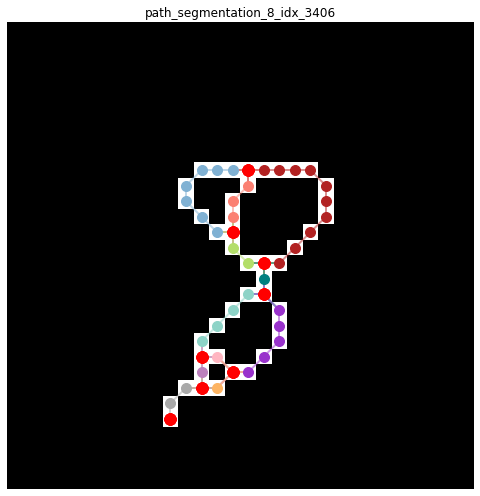

In [20]:
plot_graph_paths(path_seg_graph, skeleton, final_paths_list, path_seg_endpoints, search_by_node, label, idx)

## Other interesting examples

Let's do the same thing with the list of other interesting examples that we've previously saved.

In [21]:
# this list is length 18
interesting_examples_list = [1061, 1438, 1762, 1775, 2649, 3266,
                            3624, 3864, 3894, 4923, 5108, 5847, 
                             6344, 6428, 8493, 8865, 8951, 9688]

# this list is length 14
complex_examples_list = [620, 1411, 2023, 2358, 2638, 
                         3073, 3450, 3646, 4611, 4759,
                        5593, 7536, 9508, 9948]

# idx = interesting_examples_list[0]
# idx = complex_examples_list[0]
idx = 5165
label = mnist_labels[idx]
result_dict = result_dict_list[idx]

skeleton = result_dict["skeleton"]
graph = result_dict["skeleton_graph"]
coordinates = result_dict["skeleton_coordinates"]
# paths_list = result_dict["paths_list"]
node_types = result_dict["node_types"]
search_by_node = result_dict["search_by_node"]

junction_locations = result_dict["junction_locations"]
junction_subgraph = result_dict["junction_subgraph"]
unique_cliques = result_dict["cliques_unique"]
primary_junctions = result_dict["junctions_primary"]

path_seg_graph = result_dict["skeleton_graph_path_seg"]
removed_edges = result_dict["removed_edges"]
end_nodes = result_dict["nodes_terminal"]
path_seg_endpoints = result_dict["endpoints_path_seg"]


In [22]:
unique_cliques

[[2, 7],
 [3, 4, 15],
 [4, 5, 15],
 [5, 6, 16],
 [6, 7, 16],
 [15, 19],
 [16, 19],
 [42]]

In [23]:
primary_junctions

[2, 4, 6, 19, 42]

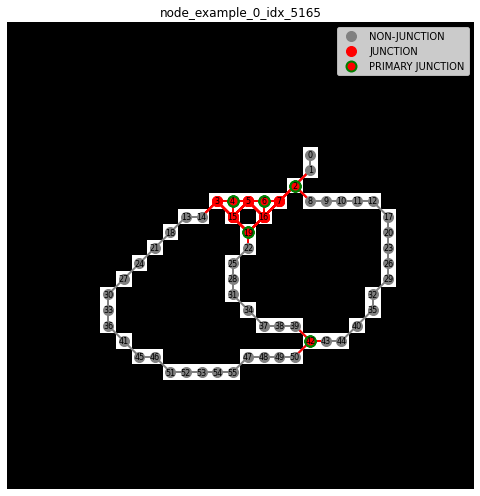

In [24]:
plot_primary_junctions(result_dict, label, idx)


In [25]:
initial_paths_list = get_initial_paths(path_seg_graph, path_seg_endpoints)

# shorten paths, remove duplicate lists
short_paths_list = sorted(list(set([tuple(shorten_path(path, path_seg_endpoints)) for path in initial_paths_list])))

# convert each path back to list type from type tuple
short_paths_list = [list(path) for path in short_paths_list]

final_paths_list = find_reversed_list(short_paths_list)


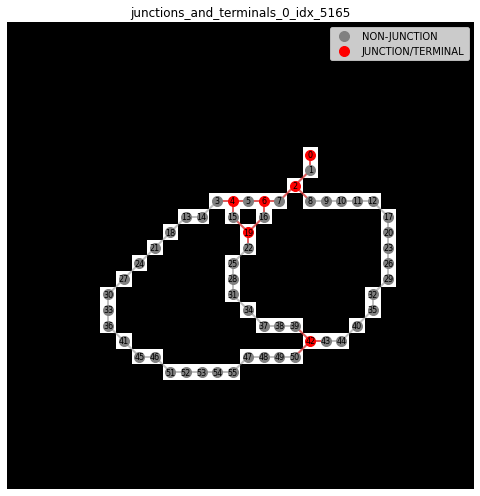

In [26]:
plot_junctions_and_terminals(result_dict, label, idx)

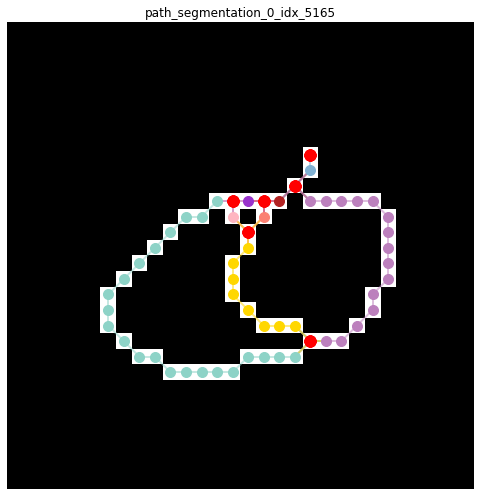

In [27]:
plot_graph_paths(path_seg_graph, skeleton, final_paths_list, path_seg_endpoints, search_by_node, label, idx)